In [56]:
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from scipy import stats



#Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler



#importing machine learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
import pickle



#Secondary imports
import pandas_profiling as pp
from scipy.stats import pearsonr
import pickle


%matplotlib inline

## Reading Datasets

In [57]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

cols = np.load('final_col.npy').tolist()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
len(cols)

234

In [59]:
remove = []

for i in range(len(cols)):
    value = (1 - train[train[cols[i]]!=0].shape[0]/train.shape[0]) * 100
    if value > 60:
        remove.append(cols[i])


for i in range(len(remove)):
    cols.remove(remove[i])

### Finding missing values, and selecting  columns with less than 5% missing values

In [60]:
seta = cols.copy()

In [61]:
percent_missing = train[seta].isnull().sum() * 100 / len(train[seta])
missing_value_df = pd.DataFrame({'column_name': train[seta].columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', ascending=False, inplace=True)
missing_value_df.reset_index(inplace=True, drop=True)

In [62]:
mis_col = missing_value_df[missing_value_df['percent_missing']<5].sort_values('percent_missing', ascending=False).column_name.values.tolist()

In [63]:
len(cols)

167

In [64]:
len(mis_col)

167

In [65]:
rf = RandomForestClassifier()


#Creating features from training dataset
features1 = train[mis_col]


targets = train['Col2']

rf.fit(features1, targets) 

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = mis_col,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


         importance
Col10          0.03
Col11          0.03
Col168         0.03
Col186         0.02
Col25          0.02
Col202         0.02
Col196         0.02
Col26          0.02
Col205         0.02
Col182         0.02
Col188         0.02
Col198         0.02
Col591         0.01
Col189         0.01
Col120         0.01
Col51          0.01
Col75          0.01
Col68          0.01
Col49          0.01
Col1688        0.01
Col1272        0.01
Col58          0.01
Col44          0.01
Col47          0.01
Col1025        0.01
Col1072        0.01
Col1210        0.01
Col1212        0.01
Col1028        0.01
Col1026        0.01
...             ...
Col1073        0.00
Col1239        0.00
Col1711        0.00
Col63          0.00
Col88          0.00
Col1081        0.00
Col1231        0.00
Col60          0.00
Col1235        0.00
Col1215        0.00
Col1347        0.00
Col1143        0.00
Col64          0.00
Col61          0.00
Col1057        0.00
Col1185        0.00
Col1241        0.00
Col1527        0.00


In [66]:
threshold = 0.001

In [67]:
thres_col = sorted(feature_importances[feature_importances.importance > threshold].reset_index()['index'].values.tolist(), key = lambda x: int(x[3:]))
print(len(thres_col))

167


In [68]:
thres_col.remove('Col32')

thres_col.remove('Col33')

In [69]:
thres_col.append('Col3')

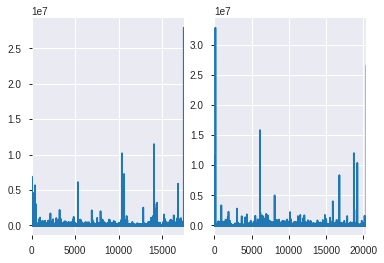

In [70]:
fig, axs = plt.subplots(1,2)

train['Col10'].plot(ax=axs[0])
test['Col10'].plot(ax=axs[1])

In [71]:
for i in thres_col:
    if train[i].nunique() >= 11:
        train[i] = train[i].ewm(span = 20).mean()
        test[i] = test[i].ewm(span = 20).mean()

## For lightgbm

In [72]:
lgbb = lgb.LGBMClassifier()
# ctb = CatBoostClassifier(verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(train[thres_col], train['Col2']):
    print("hello", count)
    count+=1
   
    trainx, testx = train[thres_col].iloc[train_index], train[thres_col].iloc[test_index]
    trainy, testy = train['Col2'].iloc[train_index], train['Col2'].iloc[test_index]
    
    lgbb.fit(trainx, trainy)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)0

hello 0
hello 1
hello 2
hello 3
hello 4
Average accuracy was:  0.8983505950403533


## Logistic Regression

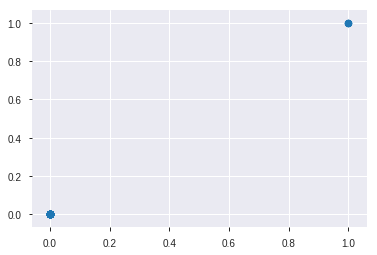

In [73]:
plt.scatter(lgbb.predict(testx), lgbb.predict(testx))

In [74]:
lgbb = LogisticRegression()
# ctb = CatBoostClassifier(verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(train[thres_col], train['Col2']):
    print("hello", count)
    count+=1
   
    trainx, testx = train[thres_col].iloc[train_index], train[thres_col].iloc[test_index]
    trainy, testy = train['Col2'].iloc[train_index], train['Col2'].iloc[test_index]
    
    lgbb.fit(trainx, trainy)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(lgbb.predict(testx), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)0

hello 0


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


hello 1


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


hello 2


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


hello 3


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


hello 4


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average accuracy was:  0.8994920498439931


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, GRU

model = Sequential()

# Embedding layer
# Recurrent layer
model.add(GRU(10, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(2, activation='softmax'))
# Compile the model
model.compile(
    optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [76]:
train_data = train[thres_col].values
train_target = train['Col2'].values

In [77]:
data_X, data_Y = [], []
for i in range(len(train_data) - 7):
    # find the end of this pattern
    end_ix = i + 0
    out_end_ix = end_ix + 7
    data_X.append(train_data[end_ix:out_end_ix, :])
    data_Y.append(train_target[end_ix])

In [78]:
data_X = np.array(data_X)
data_Y = np.array(data_Y).reshape((-1, 1))

In [79]:
data_X.shape

(17514, 7, 166)

In [80]:
data_Y.shape

(17514, 1)

In [81]:
train_data.shape

(17521, 166)

In [82]:
model.fit(data_X, data_Y)

W0928 15:39:00.094004 139818031677568 deprecation.py:506] From /usr/local/lib/python3.5/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 17514 samples
17514/17514 [==============================] - 3s 187us/sample - loss: 0.3715 - accuracy: 0.8706


In [83]:
model.predict(data_X).shape

(17514, 2)

In [89]:
path_to_weigths = './current.hdf5'
checkpoint = ModelCheckpoint(path_to_weigths, monitor='val_loss', verbose=1,
                                save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=0)


W0928 15:46:26.526282 139818031677568 callbacks.py:862] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [93]:
lgbb = LogisticRegression()
# ctb = CatBoostClassifier(verbose=False)

# xgbb = xgb.XGBClassifier()

n_split = 5
avg1 = 0
avg2 = 0
count=0

skf = StratifiedKFold(n_splits = n_split, shuffle = True)

for train_index, test_index in skf.split(data_X, data_Y):
    print("hello", count)
    count+=1
   
    trainx, testx = data_X[train_index], data_X[test_index]
    trainy, testy = data_Y[train_index], data_Y[test_index]
    
    model.fit(trainx, trainy,
             validation_data=(testx, testy),
             callbacks = [early_stopping], 
             epochs = 100)
#     ctb.fit(trainx, trainy)
    avg1 += accuracy_score(np.argmax(model.predict(testx), axis=1), testy)
#     avg2 += accuracy_score(ctb.predict(testx), testy)


print("Average accuracy was: ", avg1/n_split)#,"and", avg2/6)0

hello 0
Train on 14010 samples, validate on 3504 samples
Epoch 1/100
14010/14010 [==============================] - 3s 188us/sample - loss: 0.3276 - accuracy: 0.8995 - val_loss: 0.3269 - val_accuracy: 0.8993
Epoch 2/100
14010/14010 [==============================] - 3s 184us/sample - loss: 0.3273 - accuracy: 0.8995 - val_loss: 0.3268 - val_accuracy: 0.8993
Epoch 3/100
14010/14010 [==============================] - 3s 184us/sample - loss: 0.3271 - accuracy: 0.8995 - val_loss: 0.3266 - val_accuracy: 0.8993
Epoch 4/100
14010/14010 [==============================] - 3s 183us/sample - loss: 0.3270 - accuracy: 0.8995 - val_loss: 0.3265 - val_accuracy: 0.8993
Epoch 5/100
14010/14010 [==============================] - 3s 189us/sample - loss: 0.3265 - accuracy: 0.8995 - val_loss: 0.3271 - val_accuracy: 0.8993
Epoch 6/100
14010/14010 [==============================] - 3s 182us/sample - loss: 0.3266 - accuracy: 0.8995 - val_loss: 0.3269 - val_accuracy: 0.8993
Epoch 7/100
14010/14010 [============

In [147]:
lgbb = lgb.LGBMClassifier()
lgbb.fit(train[thres_col].values, train['Col2'].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [168]:
result = lgbb.predict(test[thres_col].values)

In [105]:
test_data = test[thres_col].values.tolist()

In [106]:
for i in range(5):
    test_data.append(test_data[-1])

In [113]:
test_data = np.array(test_data)

In [122]:
tdata_X = []
for i in range(len(test_data) - 7):
    # find the end of this pattern
    end_ix = i + 0
    out_end_ix = end_ix + 7
    tdata_X.append(test_data[end_ix:out_end_ix, :])


In [124]:
tdata_X.append(tdata_X[-1])
tdata_X.append(tdata_X[-1])

In [128]:
tdata_X = np.array(tdata_X)

In [129]:
tdata_X.shape

(20442, 7, 166)

In [130]:
test.shape

(20442, 2394)

In [132]:
model.fit(data_X, data_Y, epochs=7)

Train on 17514 samples
Epoch 1/7
17514/17514 [==============================] - 3s 166us/sample - loss: 0.3266 - accuracy: 0.8995
Epoch 2/7
17514/17514 [==============================] - 3s 164us/sample - loss: 0.3265 - accuracy: 0.8995
Epoch 3/7
17514/17514 [==============================] - 3s 165us/sample - loss: 0.3267 - accuracy: 0.8995
Epoch 4/7
17514/17514 [==============================] - 3s 165us/sample - loss: 0.3268 - accuracy: 0.8995
Epoch 5/7
17514/17514 [==============================] - 3s 164us/sample - loss: 0.3267 - accuracy: 0.8995
Epoch 6/7
17514/17514 [==============================] - 3s 166us/sample - loss: 0.3267 - accuracy: 0.8995
Epoch 7/7
17514/17514 [==============================] - 3s 164us/sample - loss: 0.3263 - accuracy: 0.8995


In [136]:
result = model.predict(tdata_X).argmax(axis=1)

In [139]:
np.unique(result, return_counts=True)

(array([0]), array([20442]))

In [169]:
submission = pd.DataFrame()
submission['Col1'] = test['Col1']
submission['Col2'] = result

In [170]:
submission.to_csv('submission.csv', index=False)

In [171]:
submission.head()

,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,0
4,RIYBGC1ZD,0
